# Phrase-structure parsing with CKY

Train a phrase-structure (constituency) parser on the [Penn Treebank](https://catalog.ldc.upenn.edu/ldc99t42), then implement exact inference using the CKY algorithm.

- **(a)** Initial preprocessing of the treebank
- **(b)** Calculation of production rule probabilities
- **(c)** Implementation of CKY algorithm

In [1]:
# Import some useful libraries...
import os
import sys
import collections
import copy
import unittest
import numpy as np
import nltk
from nltk.tree import Tree
from IPython.display import display, HTML

import logging
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# Helpers
import part2_helpers
import treeviz
import pcfg, pcfg_test
import cky, cky_test

# Use the sample of the Penn Treebank included with NLTK.
assert(nltk.download('treebank'))
corpus = nltk.corpus.treebank

# If you do install the full Penn Treebank, change the "False" to "True" below.
use_full_ptb = False
if use_full_ptb:
    part2_helpers.verify_ptb_install()
    corpus = nltk.corpus.ptb  # Throws errors, for some reason
    # This configures the corpus to use the WSJ section only.
    # The Brown section has some mis-bracketed trees that will cause the 
    # corpus reader to throw (many) errors.
    if not hasattr(corpus, '_parsed_sents'):
        print "Monkey-patching corpus reader..."
        corpus._parsed_sents = corpus.parsed_sents
        corpus.parsed_sents = lambda: corpus._parsed_sents(categories=['news'])

[nltk_data] Downloading package treebank to
[nltk_data]     /home/guangzhi_xie/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


`nltk` includes a tree drawing API, but it doesn't play nicely with SSH. We've implemented a version that uses PyDot and GraphViz, and should work on Google Cloud or any other remote server. To get it working, run the following from a terminal:

```
sudo apt-get install graphviz
pip install pydotplus
```

You should also install the [`tqdm`](https://pypi.python.org/pypi/tqdm) package, which gives progress bars. Run the cell below:

In [2]:
!pip install tqdm
from tqdm import tqdm as ProgressBar

Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.


Tree('S', [Tree('NP-SBJ', [Tree('NN', ['Compound']), Tree('NNS', ['yields'])]), Tree('VP', [Tree('VBP', ['assume']), Tree('UCP', [Tree('NP', [Tree('NP', [Tree('NN', ['reinvestment'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NNS', ['dividends'])])])]), Tree('CC', ['and']), Tree('SBAR', [Tree('IN', ['that']), Tree('S', [Tree('NP-SBJ', [Tree('DT', ['the']), Tree('JJ', ['current']), Tree('NN', ['yield'])]), Tree('VP', [Tree('VBZ', ['continues']), Tree('PP-TMP', [Tree('IN', ['for']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['year'])])])])])])])]), Tree('.', ['.'])])
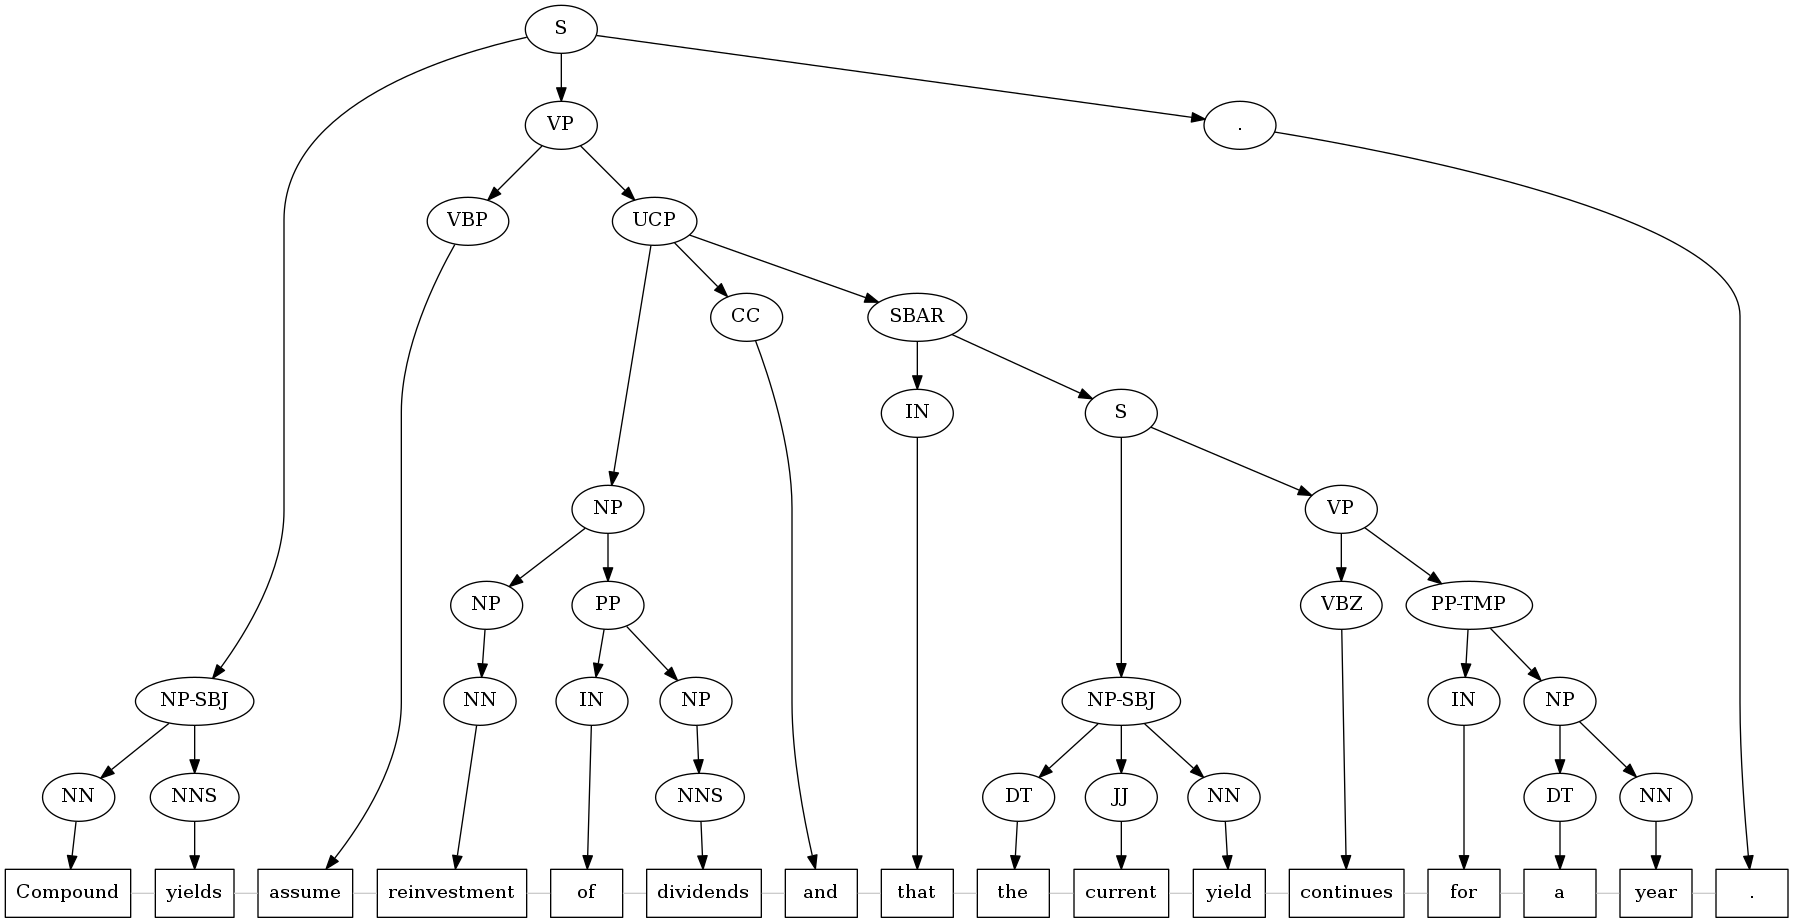

In [3]:
# Monkey-patch NLTK
# This overrides the normal Tree display if running on Cloud or other display-less server.
# if not os.getenv("DISPLAY"):
#     print "Display-less server detected!"
print "Overriding nltk.tree.Tree pretty-printing to use custom GraphViz."
nltk.tree.Tree._repr_png_ = lambda _: None
nltk.tree.Tree._repr_html_ = lambda self: treeviz.render_tree(self, title=treeviz.make_title(self),
                                                             format='png')

corpus.parsed_sents()[35]

# (a) Preprocessing

### Removing Cross-References

This first step of preprocessing takes the treebank, strips out the cross references (NPs are wrapped by special nodes that assign index numbers to them so that coreferences can be indicated).  Unfortunately, this also injects a NP-SBJ-# node between nodes you'd expect to produce one another.  Since the # changes throughout the corpus, our counts of the production rules all end up being 1 - and useless.

See NP-SBJ-1 in the tree below.  Note there is also a NP-SBJ leading to a NONE/1 subtree as a crossreference later.

In the code below we skip over nodes whose label start with NP-, connecting any children nodes to the NP-'s parent.  We also snip out any subtrees rooted by NONE.  The tree above is printed again after this next cell to illustrate the effect of this code.

### Chomsky Normal Form

Finally, CKY assumes that trees are constructed from a grammar that is in [Chomsky normal form](https://en.wikipedia.org/wiki/Chomsky_normal_form).

This means that the grammar only consists of three types of rules:
- **Binary nonterminal:** `A -> B C`
- **Unary preterminal:** `A -> a`
- **Epsilon:** `A -> `$\ \ \epsilon$

where `A`, `B`, and `C`, are non-terminals, `a` is a terminal, and $\epsilon$ is the empty sentence.

In order to accomplish this, we add new non-terminals to the language and build longer sequences of non-terminals through them.   
For example, the ternary rule
- `A -> B C D`

becomes two rules:
- `A -> B A|<C-D>`
- `A|<C-D> -> C D`

where `A|<C-D>` is a dummy symbol that we add to signifiy that it's a production of `A` that creates `C D`.

Since the resulting tree is (at most) binary, we sometimes call this process _binarization_.

#### Horizontal Markovization

The dummy-symbol system works well until you get very long grammar rules such as
- `A -> B C D E F G H I J K L`

If we followed the rule above, we'd get intermediate symbols that look like `A|<B-C-D-E-F-G-H-...>`. This would quickly lead to an explosion in the number of symbols in our grammar! Because such long productions are fairly rare, we may have trouble getting good estimates of their probability. (*Recall the sparsity problem from Week 2!*)

One way to counter this is called _horizontal Markovization_. Similar to how in language modeling, we "forgot" all history more than (n-1) words back, we can simply choose to truncate the the history and only store shorter symbols like `A|<B-C>`, `A|<C-D>`, `A|<D-E>`, and so on. This way, we can share parameters across more examples that are similar in structure.

NLTK implements this for us in the `chomsky_normal_form` function.

In [6]:
sentence = corpus.parsed_sents()[35]
# Filter out NP-* nodes.
cleaned_sentence = part2_helpers.clean_tree(sentence, simplify=True)
# Convert sentence to Chomsky normal form.
cnf_sentence = copy.deepcopy(cleaned_sentence)
nltk.treetransforms.chomsky_normal_form(cnf_sentence, horzMarkov=4)
display(HTML(treeviz.render_tree(cleaned_sentence, title="Original", format='svg')))
display(HTML(treeviz.render_tree(cnf_sentence, title="Binarized (CNF)", format='svg')))

### Run Pre-Processing on Corpus

We'll loop through the whole corpus, and make copies of each sentence in CNF form. Use the `cnf_sentences` list for training the grammar in part (b).

In [4]:
# Preprocess the treebank.
cleaned_sentences = []
cnf_sentences = []
for sentence in ProgressBar(corpus.parsed_sents(), desc="Processing sentences"):
    # Filter out NP-* nodes.
    cleaned_sentence = part2_helpers.clean_tree(sentence, simplify=True)
    cleaned_sentences.append(cleaned_sentence)
    
    # Convert sentence to Chomsky normal form.
    cnf_sentence = copy.deepcopy(cleaned_sentence)
    nltk.treetransforms.chomsky_normal_form(cnf_sentence, horzMarkov=2)
    cnf_sentences.append(cnf_sentence)

Processing sentences: 100%|██████████| 3914/3914 [00:07<00:00, 511.97it/s]


# (b) Production rule probabilities

Compute about production rule probabilities.

We won't use epsilon rules, so all of our rules will be of the form:
- Binary nonterminal: `A -> B C`
- Unary preterminal: `A -> a`

The left hand side (LHS) of these rules only ever consist of a single nonterminal.  The right hand side (RHS) consists of either two non-terminals or one terminal.

We'll do this in two stages:
- Count LHS, and (LHS,RHS) each in their own dict
- Calculate $ P(RHS | LHS) = \frac{count(LHS, RHS)}{count(LHS)} $

## Part (b) Implementation: Training the grammar

In [10]:
reload(pcfg)
reload(pcfg_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestPCFG', pcfg_test))

test_pcfg (pcfg_test.TestPCFG) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [5]:
reload(pcfg)

grammar = pcfg.PCFG()
for sentence in ProgressBar(cnf_sentences, desc="Counting productions"):
    grammar.update_counts(sentence)
    
print "Top productions:"
for p in grammar.top_productions():  # Top productions, by un-normalized count
    print p
print ""

grammar.compute_scores()  # compute log-probabilities
grammar.build_index()     # prepare for parsing

for w in ['food', 'a', 'I']:
    print w, grammar.parsing_index[(w,)]

Counting productions: 100%|██████████| 3914/3914 [00:02<00:00, 1552.93it/s]


Top productions:
(PP -> IN NP, 7369)
(, -> ',', 4885)
(DT -> 'the', 4038)
(. -> '.', 3828)
(S|<VP-.> -> VP ., 3071)
(NP -> NP PP, 2644)
(S -> VP, 2335)
(IN -> 'of', 2319)
(TO -> 'to', 2161)
(NP -> DT NN, 2020)

food [(NN, -6.7128043057880404)]
a [(LS, -2.5649493574615367), (JJ, -7.9783109698677208), (DT, -1.4717815426061982), (IN, -9.1959371416654392)]
I [(NNP, -8.4563810520194806), (PRP, -2.7203634613355669)]


In [6]:
print 'Productions (nltk.grammar.Production):'
for (production, count) in grammar.production_counts.most_common(5):
    print (production, count)

print '\n\nLHS counts:'
for (lhs, count) in grammar.lhs_counts.most_common(5):
    print (lhs, count)
    
print '\n\nLog Probabilities:'
print '\n'.join([str(x) for x in grammar.parsing_index.iteritems()][0:10])

Productions (nltk.grammar.Production):
(PP -> IN NP, 7369)
(, -> ',', 4885)
(DT -> 'the', 4038)
(. -> '.', 3828)
(S|<VP-.> -> VP ., 3071)


LHS counts:
(NP, 23766)
(VP, 14524)
(NN, 13166)
(S, 9946)
(IN, 9857)


Log Probabilities:
((u'truce',), [(NN, -8.3867807393597129)])
((VBD, VP|<RB-S>), [(VP, -9.583557732534226)])
((u'trimmed',), [(VBN, -7.6657534318616989)])
((JJ, S|<NN-PRP>), [(S|<JJ-NN>, -5.4424177105217932)])
((u'iota',), [(NN, -9.485393028027822)])
((u'unitholders',), [(NNS, -8.7073175602732125)])
((u'resolve',), [(VB, -6.7468037479243748)])
((u'waited',), [(VBD, -8.0205991498969702)])
((PRN, S|<,-NNP>), [(S|<PRN-,>, -2.0794415416798357)])
((u'Lehman',), [(NNP, -7.3577687633513715)])


# (c) Implement CKY

The chart has been implemented as a dict that we can index into first by cell position and then by non-terminal like this:
```
chart[(0, 1)][NN]
```

The value is an [nltk.tree.ProbabilisticTree](http://www.nltk.org/api/nltk.html#nltk.tree.ProbabilisticTree), which is just like an `nltk.tree.Tree` except that it has an additional `logprob()` method that returns the score (log-probability). Similarly, the constructor takes an additional argument: `pt = ProbabilisticTree(lhs, (rhs_1,...), logprob=score)` - we'll use this to construct the backtrace trees.

In [7]:
reload(cky)
reload(cky_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestParsing', cky_test))

test_failing_rule_application (cky_test.TestParsing) ... ok
test_rule_application (cky_test.TestParsing) ... ok
test_rule_application_three_words (cky_test.TestParsing) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

ProbabilisticTree(S, [ProbabilisticTree(PRP, ['I']) (p=0.15173612851696769), ProbabilisticTree(VP, [ProbabilisticTree(VBP, ['eat']) (p=0.0068668096876260687), ProbabilisticTree(VP|<NP-PP>, [ProbabilisticTree(NP, [ProbabilisticTree(JJ, ['red']) (p=0.0039654190017090543), ProbabilisticTree(NP|<JJ-NN>, [ProbabilisticTree(JJ, ['hot']) (p=0.0039654190017090543), ProbabilisticTree(NN, ['food']) (p=0.0095333282960814777)]) (p=3.2078091828121638e-05)]) (p=1.9662155367311963e-09), ProbabilisticTree(PP, [ProbabilisticTree(IN, ['with']) (p=0.10602582040574654), ProbabilisticTree(NP, [ProbabilisticTree(DT, ['a']) (p=0.36053680734251442), ProbabilisticTree(NN, ['knife']) (p=0.0013951219699423914)]) (p=9.1090931043064175e-05)]) (p=8.1464414595723497e-06)]) (p=1.3501972707728444e-14)]) (p=1.8692043100608051e-18)]) (p=5.1222272930921724e-20)
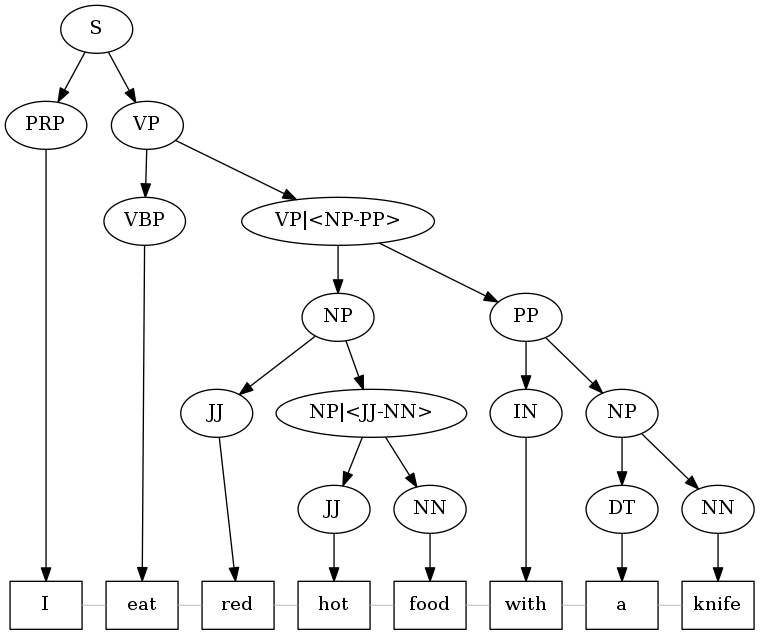

In [9]:
reload(cky)
parser = cky.CKYParser(grammar)
derivation = parser.parse('I eat red hot food with a knife'.split(), 'S')

assert round(derivation.logprob(), 2) == -64.08
derivation

### Experimentation

ProbabilisticTree(S, [ProbabilisticTree(PRP, ['We']) (p=0.082606339962070702), ProbabilisticTree(VP, [ProbabilisticTree(VBD, ['saw']) (p=0.011750278508020767), ProbabilisticTree(VP|<PRP-PP>, [ProbabilisticTree(PRP, ['him']) (p=0.039141353148380569), ProbabilisticTree(PP, [ProbabilisticTree(IN, ['on']) (p=0.12362817794264414), ProbabilisticTree(NP, [ProbabilisticTree(DT, ['the']) (p=0.61382222719119828), ProbabilisticTree(NP|<NN-NN>, [ProbabilisticTree(NN, ['way']) (p=0.014739223723122708), ProbabilisticTree(NN, ['home']) (p=0.0099424720453022541)]) (p=0.00013104559883801831)]) (p=4.3563006683690103e-06)]) (p=4.5427252792045695e-07)]) (p=1.7780841440942156e-08)]) (p=5.8314610541492671e-13)]) (p=8.6996911103646578e-15)
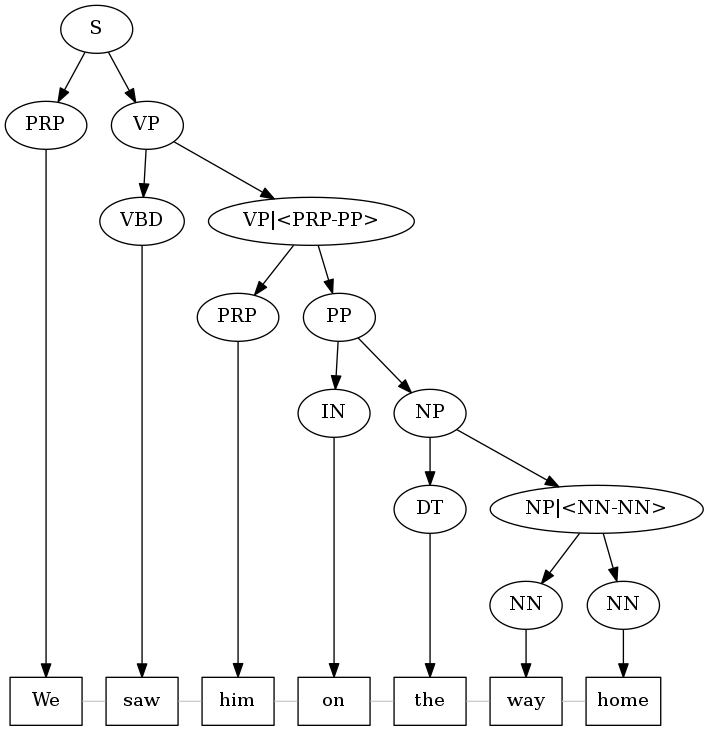

In [16]:
parser.parse('We saw him on the way home'.split(), 'S')

#### Inflexibility of Preterminal Rules
Because of the way we calculate the scores for preterminal rules, the final decision on which preterminal produces a word is largely depending on the frequency of the word's usage in the training set. For instance, in the example above, the word '**home**' should be an Adverb in the sentence, but since '**home**' is very frequently used as a Noun, it is parsed as a Noun by the parser. 

#### Attachment Ambiguity
As shown in the example above, the phrase '**on the way home**' could either be attached to '**We**' or '**him**'. However, CKY is not able to take any context information, thus the parser is not able to handle such ambiguity.